## Business Problem

Banks need to detect fraudulent credit card transactions in near real-time.

###### Challenges

* Fraud patterns change frequently

* Labels are rare & delayed

* Dataset is highly imbalanced

###### ML Objective

* Use Isolation Forest to:

* Learn normal transaction behavior

* Flag rare, abnormal transactions as potential fraud


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import shap
import joblib

In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Data Understanding

In [5]:
# class
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [6]:
# Amount distribution
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [7]:
# Time feature
df['Time'].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

###### Data Preparation

In [8]:
# Feature selection
X = df.drop(columns=['Class'])
y = df['Class'] 

In [10]:
# Feature scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

Data Splitting

Training Isolation Forest on only normal transactions

In [11]:
X_train = X_scaled[y == 0]
X_test = X_scaled

In [12]:
# Verifying
print("Training samples:", X_train.shape)
print("Total samples:", X_test.shape)

Training samples: (284315, 30)
Total samples: (284807, 30)


###### Model traing

Model configuration

In [14]:
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.0017, 
    random_state=42,
    n_jobs=-1
)

Training

In [15]:
iso_forest.fit(X_train)

IsolationForest(contamination=0.0017, n_estimators=200, n_jobs=-1,
                random_state=42)

###### Anomaly Prediction

In [16]:
y_pred = iso_forest.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [17]:
# converting to fraud-like labels
y_pred_binary = (y_pred == -1).astype(int)

y_pred_binary

array([0, 0, 0, ..., 0, 0, 0])

###### Anomaly Score

In [18]:
anomaly_scores = iso_forest.decision_function(X_test)
anomaly_scores

array([0.25044036, 0.27872112, 0.17421461, ..., 0.24148336, 0.19859716,
       0.25608477])

###### Model Evaluation

In [19]:
# checking the number of anomalies discovered
np.unique(y_pred_binary, return_counts=True)

(array([0, 1]), array([284195,    612], dtype=int64))

In [21]:
# Comparing with actual fraud labels
confusion_matrix(y, y_pred_binary)

array([[283831,    484],
       [   364,    128]], dtype=int64)

In [23]:
# evaluation
print(classification_report(y, y_pred_binary, digits=4))

              precision    recall  f1-score   support

           0     0.9987    0.9983    0.9985    284315
           1     0.2092    0.2602    0.2319       492

    accuracy                         0.9970    284807
   macro avg     0.6039    0.6292    0.6152    284807
weighted avg     0.9974    0.9970    0.9972    284807



In [25]:
# using anomaly score (roc_auc)
roc_auc = roc_auc_score(y, -anomaly_scores)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.9488083396564757


###### Threshold Tunning

In [26]:
threshold = np.percentile(anomaly_scores, 0.5)
y_custom = (anomaly_scores <= threshold).astype(int)

In [27]:
y_custom

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
# Re-evaluating
print(classification_report(y, y_custom, digits=4))

              precision    recall  f1-score   support

           0     0.9989    0.9957    0.9973    284315
           1     0.1361    0.3943    0.2024       492

    accuracy                         0.9946    284807
   macro avg     0.5675    0.6950    0.5999    284807
weighted avg     0.9975    0.9946    0.9959    284807



###### Feature Importance

In [29]:
feature_importances = np.zeros(X.shape[1])

for tree in iso_forest.estimators_:
    feature_importances += np.bincount(
        tree.tree_.feature[tree.tree_.feature >= 0],
        minlength=X.shape[1]
    )

feature_importances /= feature_importances.sum()

feature_names = X.columns

global_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": feature_importances
    })
    .sort_values(by="importance", ascending=False)
)

global_importance.head(10)

,feature,importance
0,Time,0.036171
24,V24,0.036066
22,V22,0.035960
20,V20,0.035325
16,V16,0.035219
8,V8,0.035114
14,V14,0.034796
28,V28,0.034373
10,V10,0.034268
17,V17,0.034268


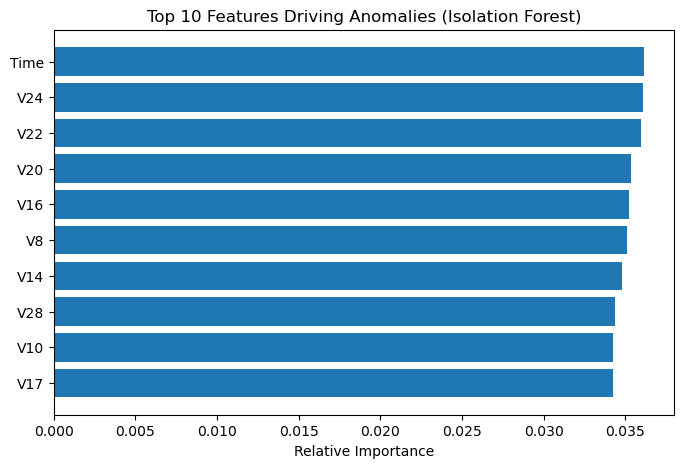

In [31]:
# Visualizing feature importances

top_features = global_importance.head(10)

plt.figure(figsize=(8, 5))
plt.barh(top_features['feature'], top_features['importance'])
plt.gca().invert_yaxis()
plt.title("Top 10 Features Driving Anomalies (Isolation Forest)")
plt.xlabel("Relative Importance")
plt.show()

###### Interpretation and validation

Global Feature Importance

| Feature                | Interpretation                                |
| ---------------------- | --------------------------------------------- |
| **Time**               | Abnormal transaction timing patterns          |
| **V24, V22, V20**      | PCA components strongly associated with fraud |
| **V16, V14, V10, V17** | Known fraud-sensitive components              |
| **V8, V28**            | Non-linear interaction indicators             |


###### Key Insight

* Importance is well distributed

* No single feature dominates 

* Matches known fraud signals in this dataset (V10, V14, V17)

###### Explainability

In [33]:
explainer = shap.TreeExplainer(iso_forest)

In [34]:
# using sample
X_sample = X_scaled[np.random.choice(X_scaled.shape[0], 1000, replace=False)]
shap_values = explainer.shap_values(X_sample)

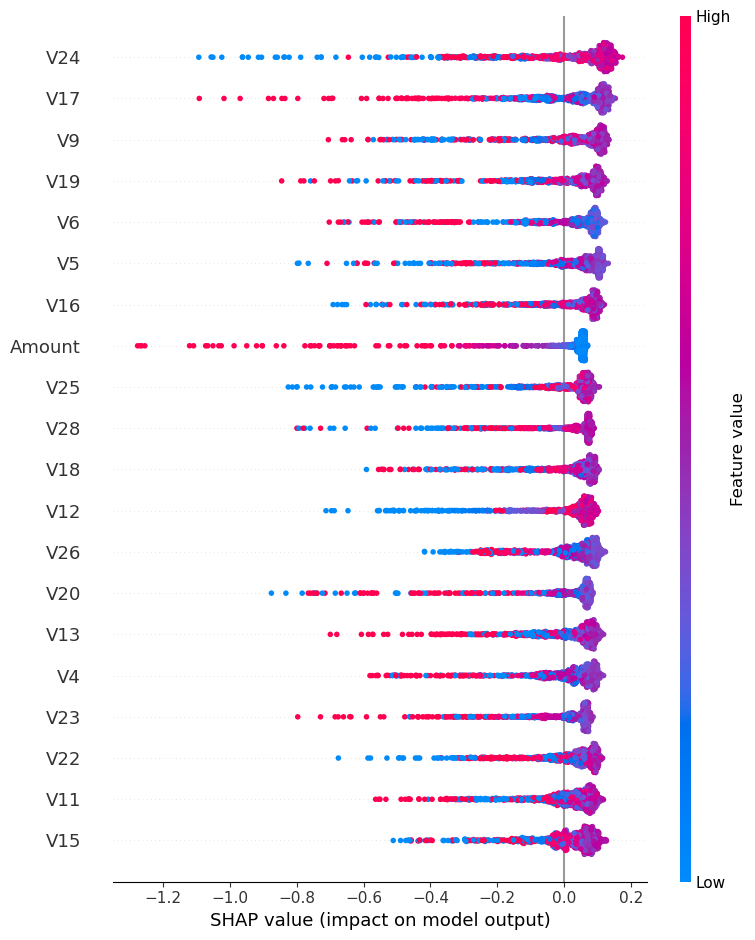

In [35]:
# visualizing shap

shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names
)


###### Interpretation

SHAP analysis shows that fraud predictions are driven by abnormal transaction amounts and extreme deviations in PCA-transformed behavioral features such as V17, V24, and V9. Both unusually high and low feature values contribute to anomaly detection, indicating non-linear fraud patterns. This confirms that the Isolation Forest model captures meaningful transaction irregularities rather than relying on single-feature thresholds.

In [36]:
# local explanation
fraud_indices = np.where(y_custom == 1)[0]
idx = fraud_indices[0]

In [37]:
idx

164

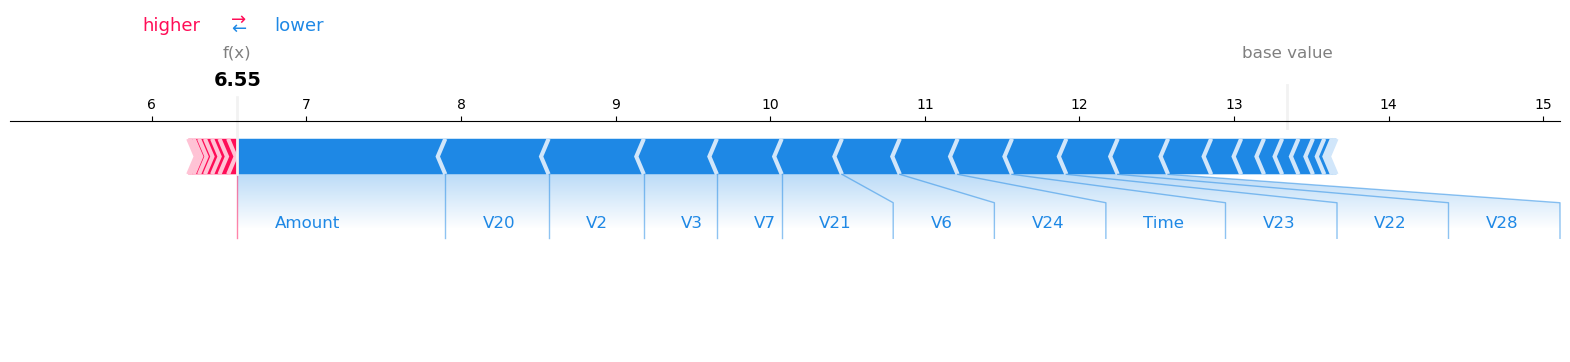

In [38]:
# Shap force plot

shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(X_scaled[idx]),
    feature_names=feature_names,
    matplotlib=True
)


###### Key insight: 
***Explainability (SHAP)***

Global: Extreme deviations in PCA features + abnormal Amount drive fraud predictions.

Local example: Individual transaction flagged due to both large Amount and PCA deviations.

Captures non-linear interactions, not just simple thresholds.

***Saving model***

In [40]:
# Save trained Isolation Forest
joblib.dump(iso_forest, "iso_forest_creditcard.pkl")

# Save scaler
joblib.dump(scaler, "scaler_creditcard.pkl")

['scaler_creditcard.pkl']